<a href="https://colab.research.google.com/github/damianmtz98/Datos_Masivos_MCD/blob/main/T1_MINIPROYECTO_SQUIDGAMES_TW_AS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import pandas as pd
import string
import re
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.dates as mdates
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

# **Analisis de sentimiento para Squid Game Netflix Twitter Data**
Se tomo una base de datos de 50 mil tweets. Esta serie de Netflix fue de las mas famosas en el año 2021 y hubo buenas o malas criticas en Twitter.

In [46]:
df = pd.read_csv('squidtw.csv', encoding='latin1')


In [47]:
df.head()

,user_id,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,1,NaN,@ManUtd die hardâ¤ï¸â¤ï¸ðªð¿ðªð¿\n...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,2,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. ...,Twitter for Android,False
2,3,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False
3,4,Any pronouns,Where the heck is the karma\nI'm going on my s...,2021-02-14 13:21:22+00:00,3,277,1341,False,2021-10-06 12:05:04+00:00,//Blood on 1st slide\nI'm joining the squidgam...,Twitter Web App,False
4,5,France,I talk and I make reactions videos about shows...,2018-12-19 20:38:28+00:00,330,152,2278,False,2021-10-06 12:05:00+00:00,"The two first games, players were killed by th...",Twitter Web App,False


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           49999 non-null  int64 
 1   user_location     35606 non-null  object
 2   user_description  46901 non-null  object
 3   user_created      49999 non-null  object
 4   user_followers    49999 non-null  int64 
 5   user_friends      49999 non-null  int64 
 6   user_favourites   49999 non-null  int64 
 7   user_verified     49999 non-null  bool  
 8   date              49999 non-null  object
 9   text              49999 non-null  object
 10  source            49999 non-null  object
 11  is_retweet        49999 non-null  bool  
dtypes: bool(2), int64(4), object(6)
memory usage: 3.9+ MB


In [81]:
tweets = df[['date','text','user_id']]
tweets.columns = ['FECHA', 'TWEET','ID']

tweets['FECHA'] = pd.to_datetime(tweets['FECHA'], infer_datetime_format=True)
tweets['FECHA'] = tweets['FECHA'].dt.strftime('%Y-%m-%d')
tweets.head(3)

,FECHA,TWEET,ID
0,2021-10-06,When life hits and the same time poverty strik...,1
1,2021-10-06,That marble episode of #SquidGame ruined me. ...,2
2,2021-10-06,#Squidgame time,3


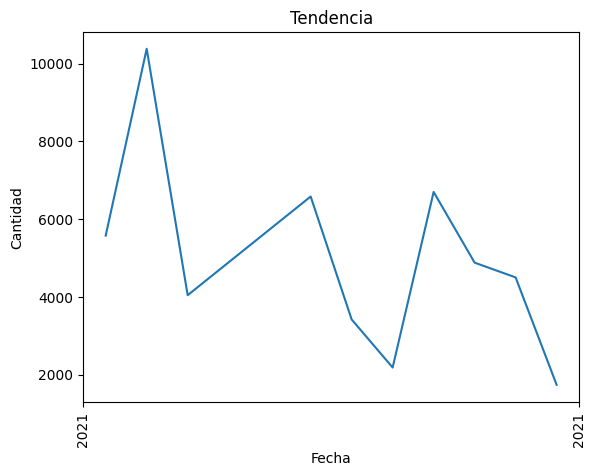

In [82]:
conteo_tweets = Counter(tweets.FECHA)
FECHA_unicas = sorted(conteo_tweets.keys())
cantidad_tweets = [conteo_tweets[FECHA] for FECHA in FECHA_unicas]
FECHA_unicas = [datetime.strptime(FECHA, "%Y-%m-%d") for FECHA in FECHA_unicas]
plt.plot(FECHA_unicas, cantidad_tweets)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Tendencia')
plt.xticks(rotation=90)
plt.show()

In [84]:
#Limpieza de datos

def limpiar_tokenizar(texto):
    newtex = texto.lower()
    newtex = re.sub('http\S+', ' ', newtex)
    regex = '[\!\"\#$\%\&\\*\+\,\-\.\/\:\;\<\=\>\?\@\^_\`\{\|\}\~]'
    newtex = re.sub(regex , ' ', newtex)
    newtex = re.sub("\d+", ' ', newtex)
    newtex = re.sub("\s+", ' ', newtex)
    newtex = newtex.split(sep = ' ')
    newtex = [token for token in newtex if len(token) > 1]
    return(newtex)

In [86]:
tweets['TWTOKEN'] = tweets['TWEET'].apply(lambda x: limpiar_tokenizar(x))
tweets[['TWEET', 'TWTOKEN']].head()

,TWEET,TWTOKEN
0,When life hits and the same time poverty strik...,"[when, life, hits, and, the, same, time, pover..."
1,That marble episode of #SquidGame ruined me. ...,"[that, marble, episode, of, squidgame, ruined,..."
2,#Squidgame time,"[squidgame, time]"
3,//Blood on 1st slide\nI'm joining the squidgam...,"[blood, on, st, slide, i'm, joining, the, squi..."
4,"The two first games, players were killed by th...","[the, two, first, games, players, were, killed..."


In [87]:
TWEETS_TIDY = tweets.explode(column='TWTOKEN')
TWEETS_TIDY = TWEETS_TIDY.drop(columns='TWEET')
TWEETS_TIDY = TWEETS_TIDY.rename(columns={'TWTOKEN':'token'})
TWEETS_TIDY.head(3)


,FECHA,ID,token
0,2021-10-06,1,when
0,2021-10-06,1,life
0,2021-10-06,1,hits


In [88]:
print(TWEETS_TIDY.columns)

Index(['FECHA', 'ID', 'token'], dtype='object')


In [91]:
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
TWEETS_TIDY = TWEETS_TIDY[~(TWEETS_TIDY["token"].isin(stop_words))]

In [101]:
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['palabra', 'puntos_sentimientos']
          )
lexicon.head()


,palabra,puntos_sentimientos
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [94]:
tweetssen = pd.merge(
                            left     = TWEETS_TIDY,
                            right    = lexicon,
                            left_on  = "token",
                            right_on = "termino",
                            how      = "inner"
                      )
tweetssen = tweetssen.drop(columns = "termino")
tweetssen = tweetssen[["FECHA", "ID", "sentimiento"]] \
                      .groupby(["FECHA", "ID"])\
                      .sum().reset_index()
tweetssen.head()


,FECHA,ID,sentimiento
0,2021-10-05,4425,2
1,2021-10-05,4428,6
2,2021-10-05,4430,1
3,2021-10-05,4431,-4
4,2021-10-05,4432,1


In [95]:

print(f"Positivos: {round(100 * np.mean(tweetssen.sentimiento > 0), 2)}")
print(f"Neutros  : {round(100 * np.mean(tweetssen.sentimiento == 0), 2)}")
print(f"Negativos: {round(100 * np.mean(tweetssen.sentimiento < 0), 2)}")


Positivos: 59.44
Neutros  : 4.0
Negativos: 36.56


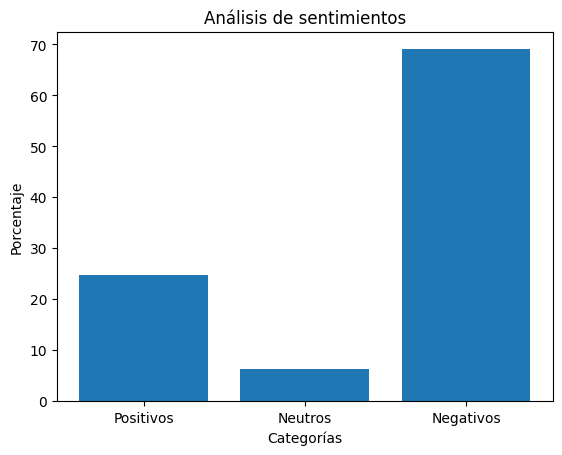

In [96]:
positivos = 24.68
neutros = 6.28
negativos = 69.04

resultados = [positivos, neutros, negativos]
etiquetas = ['Positivos', 'Neutros', 'Negativos']


plt.bar(etiquetas, resultados)


plt.title('Análisis de sentimientos')
plt.xlabel('Categorías')
plt.ylabel('Porcentaje')


plt.show()

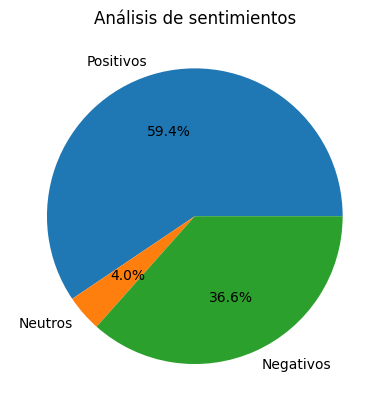

In [104]:
positivos = round(100 * np.mean(tweetssen.sentimiento > 0), 2)
neutros = round(100 * np.mean(tweetssen.sentimiento == 0), 2)
negativos = round(100 * np.mean(tweetssen.sentimiento < 0), 2)

resultados = [positivos, neutros, negativos]
etiquetas = ['Positivos', 'Neutros', 'Negativos']

# Crear el gráfico de barras
plt.pie(resultados, labels=etiquetas, autopct='%1.1f%%')
plt.title('Análisis de sentimientos')
plt.show()
